In [2]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import jax

key = jax.random.PRNGKey(420)
key2 = jax.random.PRNGKey(69)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)

In [9]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def minus_div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return -1*jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return minus_div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return -1*jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.05)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None,0)), in_axes=(0,None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None,0)), in_axes=(0,None))

def rhs(x):
    return jnp.sin(5*jnp.pi*x[0])#sp.special.ellipj(10*(x[0]-x[1]),0.99)[2]


#true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
#rhs_func = jax.vmap(rhs)#jit(jax.vmap(laplacian(true_solution_single)))

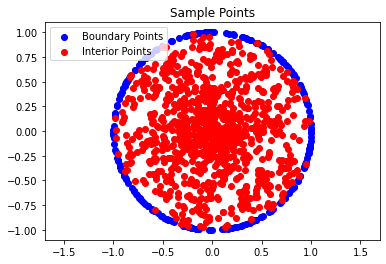

In [10]:
num_interior = 1000
num_per_boundary = 250
num_boundary=num_per_boundary

angle1 = 0; angle2 = 2*jnp.pi

# Generate random interior points
thetas = jax.random.uniform(key, shape=(num_interior,1), minval=angle1, maxval=angle2)
rs = jax.random.uniform(key2, shape=(num_interior,1))

x_interior = rs * jnp.cos(thetas)
y_interior = rs * jnp.sin(thetas)

interior_points = jnp.column_stack((x_interior, y_interior))

# Generate points on the boundary
ts = jax.random.uniform(key, shape=(num_per_boundary,1),minval=angle1, maxval=angle2)
x_boundary = jnp.cos(ts)
y_boundary = jnp.sin(ts)
boundary_points1 = jnp.column_stack((x_boundary, y_boundary))

# boundary_point_samples=np.linspace(0,1,num_per_boundary)
# x_boundary = boundary_point_samples*jnp.cos(angle1)
# y_boundary = boundary_point_samples*jnp.sin(angle1)
# boundary_points2 = jnp.column_stack((x_boundary, y_boundary))

# boundary_point_samples=np.linspace(0,1,num_per_boundary)
# x_boundary = boundary_point_samples*jnp.cos(angle2)
# y_boundary = boundary_point_samples*jnp.sin(angle2)
# boundary_points3 = jnp.column_stack((x_boundary, y_boundary))

# boundary_points = np.vstack([
#     boundary_points1,
#     boundary_points2,
#     boundary_points3,
# ])
boundary_points=boundary_points1

all_points = jnp.vstack([interior_points, boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='blue', label='Boundary Points')
plt.scatter(interior_points[:, 0], interior_points[:, 1], c='red', label='Interior Points')
plt.legend()
plt.axis('equal')
plt.show()

In [11]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(interior_points,boundary_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

#interior_rhs = rhs_func(interior_points)


TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 1 for shapes (1000, 1000), (250, 1000).

In [8]:
interior_rhs = []
for i in range(num_interior):
    interior_rhs.append(rhs(interior_points[i]))
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

In [8]:
max(interior_rhs)-min(interior_rhs)

Array(1.99999434, dtype=float64)

In [11]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')

eval_K=vec_k(all_points,all_points)
sol_vals = eval_K@coef_sol

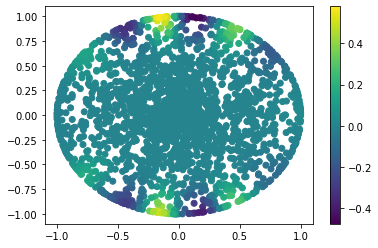

In [12]:
plt.scatter(all_points[:,0],all_points[:,1],c=sol_vals)
plt.colorbar()


In [10]:
jnp.max(jnp.abs(K_full@coef_sol-rhs_total))

Array(2.95528926e-05, dtype=float64)

In [15]:
boundary_K=vec_k(boundary_points,all_points).T


In [16]:
boundary_K@coef_sol

Array([ 0.42634231,  0.1015824 ,  0.00687965,  0.02219001, -0.21906156,
       -0.3053605 , -0.35154951, -0.00280336, -0.01209502, -0.32433879,
        0.08639198, -0.27313515,  0.00750265, -0.18419285, -0.00248362,
        0.00260415,  0.09442402,  0.03062281, -0.2903787 ,  0.49282081,
       -0.07690275, -0.01377364, -0.1248082 , -0.02194847,  0.16429794,
       -0.33294261, -0.06495015,  0.18619945, -0.01810074,  0.56282962,
       -0.07367336, -0.02650409,  0.00372019,  0.13889626, -0.02161987,
       -0.27275952, -0.15328123,  0.07552154,  0.23587141, -0.02034595,
       -0.19576126, -0.01099451, -0.36697679, -0.0191099 , -0.03056662,
       -0.11660811, -0.368617  ,  0.14118578, -0.01266389, -0.23782331,
       -0.09295459, -0.00866052, -0.09942918,  0.00381659, -0.0147763 ,
        0.23951097, -0.26910141, -0.27909393,  0.0578425 , -0.15047463,
       -0.0646752 , -0.01463325,  0.16968195,  0.4540527 , -0.0090611 ,
        0.48565918,  0.0085264 ,  0.00491678, -0.01698606,  0.02